# Air Quality in Houston - Step 2: Exploratory Data Analysis#


The datasets have been cleaned up as much as possible in the Data Wrangling notebook (which can be found under '01_DataWrangling'). Now it is time to get into the core characteristics of these datasets, explore relationships between data and define reliable features for subsequent modelling.
All modules used in this notebook are imported belowsaved dataframes.

In [153]:
### Import libraries
import numpy as np
import pandas as pd
import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sst
import geopandas as gpd
import json
import copy
from collections import defaultdict,OrderedDict, namedtuple
from sklearn.preprocessing import PowerTransformer

### Location of dataframes and mapping files
path_header='C:\\Users\\Anne\\Documents\\GIT\\TheFoxerine\\'
path_df='CP2_AQ_HOUSTON\\00_SavedDataframes\\'
path_saf='CP2_AQ_HOUSTON\\00_OriginalData\\00_StuffAndThings\\'

There are 15 excel files to load and of course as many dataframes to name. To facilitate the loading, naming and easy utilisation of the dataframes, a dictionary of dataframes 'dico_df'  is created using the module glob and the module copy. dico_df stores the name of the dataframe as key and the dataframe as value (dico_df {dataframe_name: dataframe}) and locally defines and assigns the correct name to the dataframe using the method globals(). 

In [154]:
### Create a dictionary of dataframe so that I know where to find
### the material I need without having to endlessly scroll up and down.

### empty dictionary that will contain filenames and dataframes ###
dico_df = {}

### glob fetches all xls files in the folder ###
allfiles = glob.glob(path_header+path_df + '*.xlsx')

### Because Python is all about dictionaries ;) ###
for filename in allfiles:
    df = pd.read_excel(filename,index_col=0)
    filename=filename[74::]
    filename_len=len(filename)
    filename=filename[0:(filename_len-5)]
    key_name = str(filename)    
    dico_df[key_name] = copy.deepcopy(df)

### dico_df is ready
### the key is the name of the df
### the value is the df itself
print(dico_df.keys())


dict_keys(['epa', 'epa_co', 'epa_no2', 'epa_ozone', 'epa_pb', 'epa_pm10', 'epa_pm25', 'epa_so2', 'meteo_simple', 'riopa_indoor', 'riopa_outdoor', 'riopa_slim', 'stations_all', 'stations_epa', 'stations_epatamis', 'stations_meteo', 'stations_tamis', 'tamis_co', 'tamis_no2', 'tamis_ozone', 'tamis_pb', 'tamis_pm10', 'tamis_pm25', 'tamis_so2'])


In [155]:
### Let's unwrap all df with the correct name
for k,v in dico_df.items():
    globals()[f'{k}'] =v
    
### Let's look at one df, epa_co
epa_co.head()

,date,co_8hr_source,co_8hr_poc,site_id,co_8hr_max,co_8hr_units,site_name,co_8hr_obs_count,site_lat,site_lon
0,2008-01-01,AQS,1,482010024,0.2,ppm,Houston Aldine,19,29.901036,-95.326137
1,2008-01-02,AQS,1,482010024,0.3,ppm,Houston Aldine,24,29.901036,-95.326137
2,2008-01-03,AQS,1,482010024,0.3,ppm,Houston Aldine,24,29.901036,-95.326137
3,2008-01-04,AQS,1,482010024,0.2,ppm,Houston Aldine,24,29.901036,-95.326137
4,2008-01-05,AQS,1,482010024,0.3,ppm,Houston Aldine,24,29.901036,-95.326137


## 1. Indoor vs. Outdoor (RIOPA) ##
The RIOPA data is being used in this project to attempt to model indoor air from outdoor air data and additional categories such as landuse, ambient data, weather...etc..

### 1.1. Exploring the RIOPA Data: ###
The indoor and outdoor data are saved in the dataframes 'riopa_indoor' and riopa_outdoor', respectively. The outdoor data lacks 'land use' and 'location' information because it was not provided with the original report for outdoor data and the linkid of outdoor data is different from the one for indoor data. I need this information to plot the outdoor data and later to be able to connect this outdoor data to the EPA and TECQ/Tamis data.
As the outdoor sampling was done close to the home where the indoor sampling was performed, I will just add the land use, location longitude, location latitude, census block code and geoid number from the indoor data to the outdoor data.
There is a little trick in the linkid: the linkid of indoor data ends by '10' whereas the linkid of the outdoor data ends by '20'. The 6 first digits of the linkid is the link between outdoor and indoor entries. Consequently, I will merge land use and location information from the riopa_indoor dataset to the riopa_outdoor dataset on a 6 digit linkid.

In [156]:
riopa_indoor.head()

,linkid,sampleid,homeid,airtype,pm25,date_start_pm25,date_end_pm25,date,landuse_class,ambient_temp_c,ambient_rh,airexrate,temp_dry,dew_point,temp_wet,rh,census_group_block_code,home_lat,home_long
0,TX103110,10951,EX103,INDOOR,15.2,2000-10-17,2000-10-19,2000-10-17,deciduous forest,21.1000,0.0000,0.176838,69.283667,60.049633,63.702133,75.858133,4.820125e+11,29.787702,-95.096897
3,TX104110,10889,EX104,INDOOR,13.0,2000-09-26,2000-09-28,2000-09-26,high intensity residential,18.3300,0.0000,2.384460,66.305533,51.388900,57.777800,63.458333,4.820125e+11,NaN,NaN
7,TX106110,10965,EX106,INDOOR,9.3,2000-11-09,2000-11-11,2000-11-09,"pasture, hay",0.0000,0.0000,0.000000,51.127667,43.808500,47.539033,78.886533,4.820125e+11,NaN,NaN
10,TX104210,10986,EX204,INDOOR,17.2,2000-12-15,2000-12-17,2000-12-15,high intensity residential,19.4908,49.3269,2.465370,52.046667,36.953333,45.780000,61.353333,4.820125e+11,NaN,NaN
14,TX106210,10982,EX206,INDOOR,11.6,2001-01-15,2001-01-17,2001-01-15,"pasture, hay",0.0000,0.0000,1.713790,52.573567,49.035600,50.758567,89.278933,4.820125e+11,NaN,NaN


In [157]:
riopa_indoor.shape

(120, 19)

In [158]:
riopa_outdoor.shape

(126, 19)

In [159]:
riopa_indoor.linkid.unique()

array(['TX103110', 'TX104110', 'TX106110', 'TX104210', 'TX106210',
       'TX001110', 'TX002110', 'TX004110', 'TX005110', 'TX006110',
       'TX007110', 'TX008110', 'TX009110', 'TX010110', 'TX011110',
       'TX012110', 'TX013110', 'TX014110', 'TX015110', 'TX016110',
       'TX017110', 'TX018110', 'TX020110', 'TX021110', 'TX022110',
       'TX023110', 'TX024110', 'TX025110', 'TX026110', 'TX027110',
       'TX028110', 'TX029110', 'TX030110', 'TX032110', 'TX033110',
       'TX034110', 'TX035110', 'TX036110', 'TX037110', 'TX038110',
       'TX039110', 'TX040110', 'TX041110', 'TX042110', 'TX043110',
       'TX044110', 'TX045110', 'TX046110', 'TX047110', 'TX048110',
       'TX049110', 'TX050110', 'TX051110', 'TX052110', 'TX054110',
       'TX055110', 'TX056110', 'TX057110', 'TX058110', 'TX059110',
       'TX063110', 'TX064110', 'TX072110', 'TX073110', 'TX074110',
       'TX076110', 'TX092110', 'TX001210', 'TX002210', 'TX003210',
       'TX004210', 'TX005210', 'TX006210', 'TX008210', 'TX0092

In [160]:
riopa_outdoor.linkid.unique()

array(['TX103120', 'TX104120', 'TX106120', 'TX104220', 'TX001120',
       'TX002120', 'TX003120', 'TX004120', 'TX005120', 'TX006120',
       'TX007120', 'TX009120', 'TX010120', 'TX011120', 'TX012120',
       'TX013120', 'TX014120', 'TX015120', 'TX016120', 'TX017120',
       'TX018120', 'TX019120', 'TX020120', 'TX021120', 'TX022120',
       'TX023120', 'TX024120', 'TX025120', 'TX026120', 'TX027120',
       'TX028120', 'TX029120', 'TX030120', 'TX031120', 'TX032120',
       'TX033120', 'TX034120', 'TX035120', 'TX036120', 'TX037120',
       'TX038120', 'TX039120', 'TX040120', 'TX041120', 'TX042120',
       'TX043120', 'TX044120', 'TX045120', 'TX046120', 'TX047120',
       'TX048120', 'TX049120', 'TX050120', 'TX051120', 'TX052120',
       'TX053120', 'TX055120', 'TX056120', 'TX057120', 'TX058120',
       'TX059120', 'TX063120', 'TX064120', 'TX072120', 'TX073120',
       'TX074120', 'TX076120', 'TX092120', 'TX001220', 'TX002220',
       'TX003220', 'TX004220', 'TX005220', 'TX006220', 'TX0072

In [161]:
### Drop excess information (additional date columns)
### Select the essential. I chose to subset instead of 
### dropping the columns so that I can quickly copy paste
### column names I would need later
riopa_interest=['date','linkid','sampleid','homeid','airtype',
                'pm25',
                'landuse_class','ambient_temp_c','ambient_rh','airexrate',
                'temp_dry','dew_point','temp_wet','rh',
                'census_group_block_code','home_lat','home_long']
indoor=riopa_indoor[riopa_interest]
outdoor=riopa_outdoor[riopa_interest]

### Drop landuse_class and location information
### in outdoor that contains only 'tbd' or 'nan'
outdoor.drop(['landuse_class','census_group_block_code','home_lat','home_long'],axis=1,inplace=True)

### Create the column common_id which is the first digit of linkid
indoor['common_id']=indoor['linkid'].str[:6]
outdoor['common_id']=outdoor['linkid'].str[:6]

### Get a subset of indoor containing the common_id, landuse and location information
foroutdoor=indoor[['common_id','landuse_class','census_group_block_code','home_lat','home_long']]

### Merge the subset to outdoor on common_id
outdoor2=pd.merge(outdoor, foroutdoor, on=['common_id'], how='left')

outdoor2.isnull().sum()

C:\Users\Anne\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Anne\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Anne\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

date                        0
linkid                      0
sampleid                    0
homeid                      0
airtype                     0
pm25                        0
ambient_temp_c              0
ambient_rh                  0
airexrate                   0
temp_dry                    1
dew_point                   1
temp_wet                    1
rh                          1
common_id                   0
landuse_class              11
census_group_block_code    12
home_lat                   93
home_long                  93
dtype: int64

The high number of null values for home_lat and home_lon is explained by the fact that most groupblock ID numbers provided by the RIOPA team are wrong. This is real life data with real life issues as often encountered in Data Science. I won't be able to plot the data geographically ansd relate it to what I wanted to in the first place however I can still use 'common_id' as a substitute for location. 
As a consequence, missing 'landuse_class' will be replaced by 'unknown'. For the indoor dataframe, there are 4 missing values related to outdoor temperature and rh and two missing blockgroup code. These are not important because they are not part of what the indoor data is defined by and the block group codes are wrong anyway. There in one 'NaT' in the date column - the row will be deleted.
The dataframes are consequently trimmed down again.

In [162]:
### Trimming down
indoor2=indoor[['date', 'homeid', 'airtype', 'pm25', 'landuse_class',
                'ambient_temp_c', 'ambient_rh', 'airexrate',
                'temp_dry', 'dew_point', 'temp_wet', 'rh', 'common_id']]
outdoor3=outdoor2[['date', 'homeid', 'airtype', 'pm25','landuse_class',
                   'ambient_temp_c', 'ambient_rh', 
                   'temp_dry', 'dew_point','temp_wet', 'rh', 'common_id']]

### Dropping row where Date is NaT
indoor2=indoor2.loc[indoor2.date.notnull()]
outdoor3=outdoor3.loc[outdoor3.date.notnull()]

In [163]:
indoor2.isnull().sum()

date              0
homeid            0
airtype           0
pm25              0
landuse_class     0
ambient_temp_c    0
ambient_rh        0
airexrate         0
temp_dry          4
dew_point         4
temp_wet          4
rh                4
common_id         0
dtype: int64

In [164]:
outdoor3.isnull().sum()

date               0
homeid             0
airtype            0
pm25               0
landuse_class     11
ambient_temp_c     0
ambient_rh         0
temp_dry           1
dew_point          1
temp_wet           1
rh                 1
common_id          0
dtype: int64

In [165]:
outdoor3.head()

,date,homeid,airtype,pm25,landuse_class,ambient_temp_c,ambient_rh,temp_dry,dew_point,temp_wet,rh,common_id
0,2000-10-17,EX103,OUTDOOR,17.8,deciduous forest,21.4366,0.0000,69.277767,60.208333,63.791667,76.263867,TX1031
1,2000-09-26,EX104,OUTDOOR,13.4,high intensity residential,19.0117,0.0000,66.402800,51.402767,57.826400,63.291667,TX1041
2,2000-11-09,EX106,OUTDOOR,13.6,"pasture, hay",28.4035,0.0000,51.291700,43.597233,47.534700,78.055533,TX1061
3,2000-12-15,EX204,OUTDOOR,3.6,high intensity residential,12.1109,66.0289,52.046667,36.953333,45.780000,61.353333,TX1042
4,1999-06-23,TX001,OUTDOOR,9.3,low intensity residential,27.0800,0.0000,80.732667,76.141533,77.472800,86.693867,TX0011


As shown below, the datasets are small: indoor2 contains 120 PM 2.5 measurements, which should be the target value; and outdoor3 contains 130 PM 2.5 measurements, which should be one of the predictor value. 
A quick note on terms, PM 2.5 is a common pollutant. PM stands for "Particulate Matter". "2.5" is the size of the particle in microns (small enough to snuggle in your lungs).

In [166]:
indoor2.describe().T

,count,mean,std,min,25%,50%,75%,max
pm25,120.0,16.810000,12.394390,3.000000,8.850000,13.400000,22.450000,78.900000
ambient_temp_c,120.0,21.309354,8.423788,0.000000,22.257050,23.900000,25.696575,30.460000
ambient_rh,120.0,32.172313,26.910208,0.000000,0.000000,45.419150,55.561125,80.246500
airexrate,120.0,0.877188,1.634181,0.000000,0.229308,0.425154,0.765725,13.343200
temp_dry,116.0,72.374966,10.569739,46.465300,65.948742,73.486583,81.771642,86.309233
dew_point,116.0,62.894073,11.493048,26.233767,58.015958,66.229583,72.468992,76.141533
temp_wet,116.0,66.549028,10.030153,38.276433,61.391400,68.598217,74.945950,78.067267
rh,116.0,75.233762,9.310597,48.258500,68.282617,76.751633,82.905200,91.163267


In [167]:
outdoor3.describe().T

,count,mean,std,min,25%,50%,75%,max
pm25,130.0,14.613077,5.613127,3.600000,10.700000,13.150000,17.575000,34.000000
ambient_temp_c,130.0,23.001333,6.506294,0.000000,19.426475,24.149750,28.642700,32.468800
ambient_rh,130.0,45.834556,38.460267,0.000000,0.000000,63.677200,80.874525,103.911000
temp_dry,129.0,72.990797,10.759285,46.397167,66.229800,74.164800,82.361100,88.794467
dew_point,129.0,63.214449,11.593871,26.453567,58.699267,66.834467,72.302300,76.141533
temp_wet,129.0,66.947269,10.115425,38.418000,62.316700,69.594667,75.224700,78.081800
rh,129.0,74.616001,9.267294,47.787800,68.021267,76.457033,82.322900,91.163267


The statistical summaries of indoor2 and outdoor3 show zero values as minimum for 'ambient_temp_c', 'ambient_rh' and 'airexrate'. The zeroes are likely 'missing measurements'. As these curves are time series we can fill them up later using interpolation, after figuring out the star variable 'PM 2.5'.

Outliers within the PM 2.5 or other pollutant concentrations are important data because they represent crisis events where concentrations go beyong healthy limits and therefore should be identified and counted. Boxplots are a good way to show outliers, median and mean.

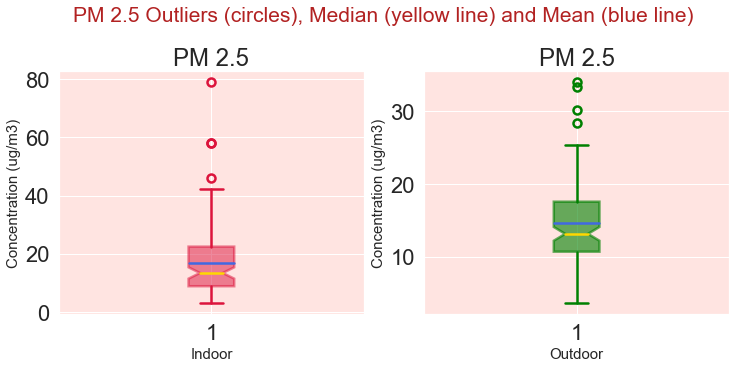

In [168]:
fig, (boxind, boxout)= plt.subplots(1, 2, figsize=(12, 5), frameon=True)
fig.suptitle('PM 2.5 Outliers (circles), Median (yellow line) and Mean (blue line)', size=21, color='firebrick')
fig.subplots_adjust(top=0.8)
### plt.boxplot(data,sym='',widths=0.75, patch_artist=True)

medianprops1 = dict(linestyle='-', linewidth=2.5, color='gold')
meanlineprops1 = dict(linestyle='-', linewidth=2.5, color='royalblue')

boxind.set_title('PM 2.5')
boxind.boxplot(indoor2.pm25,
               boxprops=dict(linestyle='-', linewidth=2.5, facecolor='crimson',color='crimson', alpha=0.5),
               flierprops=dict(marker='o', markersize=8, linestyle='none', markeredgecolor='crimson', markeredgewidth=2.5),
               medianprops=medianprops1, meanprops=meanlineprops1, showmeans=True, meanline=True,
               patch_artist=True, notch=True,
               whiskerprops=dict(color='crimson', linewidth=2.5),
               capprops=dict(color='crimson', linewidth=2.5))
boxind.set(xlabel='Indoor', ylabel='Concentration (ug/m3)')
boxind.xaxis.get_label().set_fontsize(15)
boxind.yaxis.get_label().set_fontsize(15)
boxind.set_facecolor('mistyrose')
boxind.grid(True)

boxout.boxplot(outdoor3.pm25,
               boxprops=dict(linestyle='-', linewidth=2.5, facecolor='green',color='green', alpha=0.6),
               flierprops=dict(marker='o', markersize=8, linestyle='none', markeredgecolor='green', markeredgewidth=2.5),
               medianprops=medianprops1, meanprops=meanlineprops1, showmeans=True, meanline=True,
               patch_artist=True, notch=True,
               whiskerprops=dict(color='green', linewidth=2.5),
               capprops=dict(color='green',linewidth=2.5))
boxout.set(xlabel='PM 2.5', ylabel='Concentration (ug/m3)')
boxout.set_title('PM 2.5')
boxout.set(xlabel='Outdoor')
boxout.xaxis.get_label().set_fontsize(15)
boxout.yaxis.get_label().set_fontsize(15)
boxout.set_facecolor('mistyrose')
boxout.grid(True)

plt.show()

While the mean and median values of indoor (16.8 ug/m3, 13.4 ug/m3) and outdoor (14.6 ug/m3, 13.2 ug/m3) PM 2.5 concentrations are close, the indoor concentrations spread towards higher values (i.e. the end of 4th quartile at 42 ug/m3 with outliers up to 80 ug/m3) than the outdoor concentrations (i.e. remain below 35 ug/m3).

Going back to the Data Wrangling Notebook, I checked remarks/comments and other measurements found in the original file PM_Mass.xlsx. The reasons behind the outliers are:

- The extreme indoor value at 78.9 ug/m3 is not associated with an outdoor value because the electricity went off as stated in the PM_Mass.xlsx ("the Harvard outdoor final flow not taken because electricity went off"). I choose to drop it from the indoor dataframe.
- The extreme indoor value at 58.2 ug/m3 has been measured from 04/10/2000 to 04/12/2000 in homeid TX047. Another measurement was taken from 04/12/2000 to 04/14/2000 which showed a value of 8 ug/m3 which is closer to the outdoor value of 6 ug/m3 measured during the same time period. I choose to drop the value 58.2 because I think an indoor source was responsible for providing additional PM 2.5.
- For the extreme indoor value of 58.2 ug/m3 in homeid TX007. The associated outdoor value is 26 ug/m3. There was likely an indoor source of PM 2.5.
- Indoor outliers in the 40s are fine.

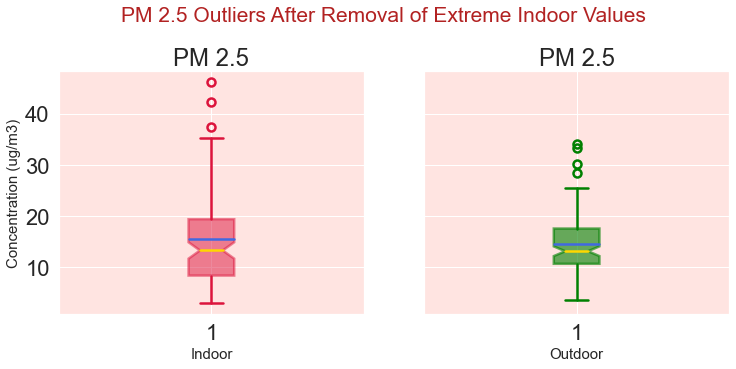

In [169]:
### removing selected outliers
cond1=indoor2.pm25 != 78.9
cond2=indoor2.pm25 != 58.2
indoor3=indoor2[cond1 & cond2]

fig, (boxind2, boxout2)= plt.subplots(1, 2, figsize=(12, 5), sharey=True, frameon=True)
fig.suptitle('PM 2.5 Outliers After Removal of Extreme Indoor Values', size=21, color='firebrick')
fig.subplots_adjust(top=0.8)
### plt.boxplot(data,sym='',widths=0.75, patch_artist=True)

medianprops1 = dict(linestyle='-', linewidth=2.5, color='gold')
meanlineprops1 = dict(linestyle='-', linewidth=2.5, color='royalblue')

boxind2.set_title('PM 2.5')
boxind2.boxplot(indoor3.pm25,
               boxprops=dict(linestyle='-', linewidth=2.5, facecolor='crimson',color='crimson', alpha=0.5),
               flierprops=dict(marker='o', markersize=8, linestyle='none', markeredgecolor='crimson', markeredgewidth=2.5),
               medianprops=medianprops1, meanprops=meanlineprops1, showmeans=True, meanline=True,
               patch_artist=True, notch=True,
               whiskerprops=dict(color='crimson', linewidth=2.5),
               capprops=dict(color='crimson', linewidth=2.5))
boxind2.set(xlabel='Indoor', ylabel='Concentration (ug/m3)')
boxind2.xaxis.get_label().set_fontsize(15)
boxind2.yaxis.get_label().set_fontsize(15)
boxind2.set_facecolor('mistyrose')
boxind2.grid(True)

boxout2.boxplot(outdoor3.pm25,
               boxprops=dict(linestyle='-', linewidth=2.5, facecolor='green',color='green', alpha=0.6),
               flierprops=dict(marker='o', markersize=8, linestyle='none', markeredgecolor='green', markeredgewidth=2.5),
               medianprops=medianprops1, meanprops=meanlineprops1, showmeans=True, meanline=True,
               patch_artist=True, notch=True,
               whiskerprops=dict(color='green', linewidth=2.5),
               capprops=dict(color='green',linewidth=2.5))
boxout2.set(xlabel='PM 2.5')
boxout2.set_title('PM 2.5')
boxout2.set(xlabel='Outdoor')
boxout2.xaxis.get_label().set_fontsize(15)
boxout2.yaxis.get_label().set_fontsize(15)
boxout2.set_facecolor('mistyrose')
boxout2.grid(True)

plt.show()

There are still outliers but these ones are fine (as in I cannot justify getting rid of them with the data I have). As stated before, recording abnormal high concentration events are important in air quality monitoring.
From the boxplots, we can expect the distribution of both indoor and outdoor PM 2.5 to be centered around the same mean value, with the indoor distribution being wider than the outdoor values. Hopefully they will be normally distributed.

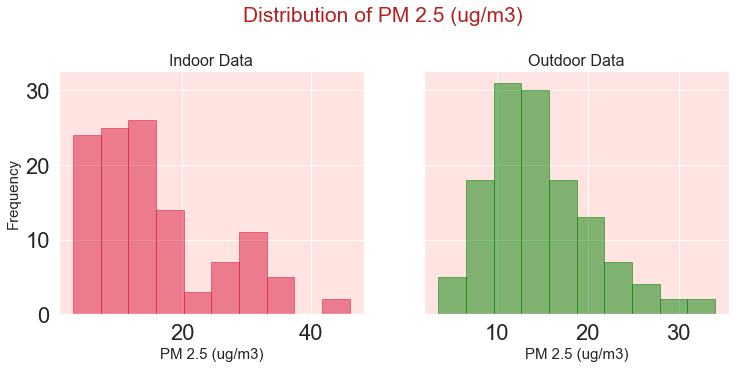

In [170]:
### Plot pm25 distribution indoor and outdoor
fig, (ind, out) = plt.subplots(1, 2, sharey=True, figsize=(12, 5), frameon=True)
fig.suptitle('Distribution of PM 2.5 (ug/m3)', fontsize=21, color='firebrick')
fig.subplots_adjust(top=0.8)

ind.hist(data=indoor3, x='pm25', bins=10, alpha=0.5, facecolor='crimson', 
         linewidth=1, histtype='bar', ec='crimson')
ind.set_title('Indoor Data', fontsize=16)
ind.set(xlabel='PM 2.5 (ug/m3)', ylabel='Frequency')
ind.xaxis.get_label().set_fontsize(15)
ind.yaxis.get_label().set_fontsize(15)
ind.set_facecolor('mistyrose')
ind.grid(True)

out.hist(data=outdoor3, x='pm25', bins=10, alpha=0.5, facecolor='green', 
         linewidth=1, histtype='bar', ec='green')
out.set_title('Outdoor Data', fontsize=16)
out.set(xlabel='PM 2.5 (ug/m3)')
out.xaxis.get_label().set_fontsize(15)
out.set_facecolor('mistyrose')
out.grid(True)

plt.show()

The overall distribution of PM 2.5 is right-skewed for both indoor and outdoor datasets. To attempt to reach a normal distribution, the data is being log transformed below and replotted.

C:\Users\Anne\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Anne\anaconda3\lib\site-packages\pandas\core\indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
C:\Users\Anne\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

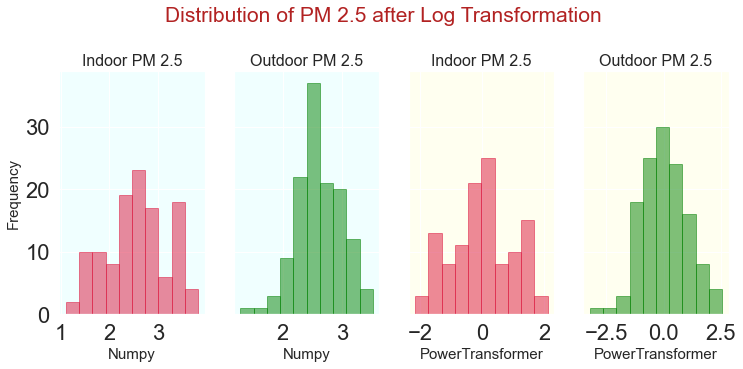

In [171]:
### Apply log transform on the column pm25
### with Numpy np.log
outdoor3['pm25_log_np']=np.log(outdoor3.pm25)
indoor3['pm25_log_np']=np.log(indoor3.pm25)

### with PowerTransformer box-cox
ptlog=PowerTransformer(method='box-cox')
indoor3[['pm25_log_pt']]=ptlog.fit_transform(indoor3[['pm25']])
outdoor3[['pm25_log_pt']]=ptlog.fit_transform(outdoor3[['pm25']])

### Plot log(pm25) distribution indoor and outdoor
fig, (log_ind, log_out, ptlog_ind, ptlog_out) = plt.subplots(1, 4, sharey=True, figsize=(12, 5), frameon=True)
fig.suptitle('Distribution of PM 2.5 after Log Transformation', fontsize=21, color='firebrick')
fig.subplots_adjust(top=0.8)

log_ind.hist(data=indoor3, x='pm25_log_np', bins=10, alpha=0.5, facecolor='crimson', 
         linewidth=1, histtype='bar', ec='crimson')
log_ind.set_title('Indoor PM 2.5', fontsize=16)
log_ind.set(xlabel='Numpy', ylabel='Frequency')
log_ind.xaxis.get_label().set_fontsize(15)
log_ind.yaxis.get_label().set_fontsize(15)
log_ind.set_facecolor('azure')
log_ind.grid(True)

log_out.hist(data=outdoor3, x='pm25_log_np', bins=10, alpha=0.5, facecolor='green', 
         linewidth=1, histtype='bar', ec='green')
log_out.set_title('Outdoor PM 2.5', fontsize=16)
log_out.set(xlabel='Numpy')
log_out.xaxis.get_label().set_fontsize(15)
log_out.set_facecolor('azure')
log_out.grid(True)

ptlog_ind.hist(data=indoor3, x='pm25_log_pt', bins=10, alpha=0.5, facecolor='crimson', 
         linewidth=1, histtype='bar', ec='crimson')
ptlog_ind.set_title('Indoor PM 2.5', fontsize=16)
ptlog_ind.set(xlabel='PowerTransformer')
ptlog_ind.xaxis.get_label().set_fontsize(15)
ptlog_ind.yaxis.get_label().set_fontsize(15)
ptlog_ind.set_facecolor('ivory')
ptlog_ind.grid(True)

ptlog_out.hist(data=outdoor3, x='pm25_log_pt', bins=10, alpha=0.5, facecolor='green', 
         linewidth=1, histtype='bar', ec='green')
ptlog_out.set_title('Outdoor PM 2.5', fontsize=16)
ptlog_out.set(xlabel='PowerTransformer')
ptlog_out.xaxis.get_label().set_fontsize(15)
ptlog_out.set_facecolor('ivory')
ptlog_out.grid(True)

plt.show()

After log transformation both PM 2.5 distributions do look normal enough.The function 'stats.normaltest' is a scipy function which tests the null hypothesis that a sample comes from a normal distribution (p>0.001). The results of normaltest (below) confirm the log distributions are normal. When it comes to pick one fo the transofrmation, I choose the PowerTransformer distribution because of the p values and the density plots (both below).

In [172]:
stat_ind, p_ind= sst.normaltest(indoor3.pm25)
stat_out, p_out= sst.normaltest(outdoor3.pm25)
stat_indlog_np, p_indlog_np= sst.normaltest(indoor3.pm25_log_np)
stat_outlog_np, p_outlog_np= sst.normaltest(outdoor3.pm25_log_np)
stat_indlog_pt, p_indlog_pt= sst.normaltest(indoor3.pm25_log_pt)
stat_outlog_pt, p_outlog_pt= sst.normaltest(outdoor3.pm25_log_pt)
print('Normal test results indoor: s2+k2=', stat_ind,' and p=', p_ind)
print('Normal test results outdoor: s2+k2=', stat_out, ' and p=', p_out)
print('Normal test results indoor (numpy log): s2+k2=', stat_indlog_np,' and p=', p_indlog_np)
print('Normal test results outdoor(numpy log): s2+k2=', stat_outlog_np, ' and p=', p_outlog_np)
print('Normal test results indoor (powertransformer): s2+k2=', stat_indlog_pt,' and p=', p_indlog_pt)
print('Normal test results outdoor (powertransformer): s2+k2=', stat_outlog_pt, ' and p=', p_outlog_pt)

Normal test results indoor: s2+k2= 15.600832971360312  and p= 0.00040956436575983004
Normal test results outdoor: s2+k2= 22.29970378229126  and p= 1.4377416355008872e-05
Normal test results indoor (numpy log): s2+k2= 5.718427989438606  and p= 0.05731379150853403
Normal test results outdoor(numpy log): s2+k2= 2.5825690383427276  and p= 0.2749174194913027
Normal test results indoor (powertransformer): s2+k2= 6.082419673381022  and p= 0.04777705208376711
Normal test results outdoor (powertransformer): s2+k2= 0.8128253909672551  and p= 0.6660352409624517


[]

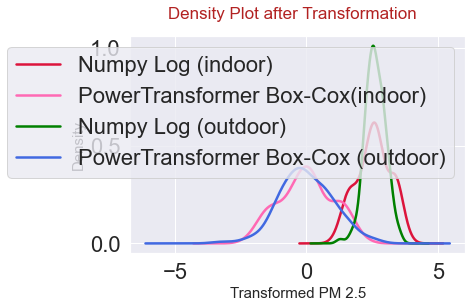

In [173]:
plt.suptitle('Density Plot after Transformation', fontsize=17, color='firebrick')
#plt.figure(figsize=[5,5])
indoor3.pm25_log_np.plot(kind='kde', c='crimson', linewidth=2.5)
indoor3.pm25_log_pt.plot(kind='kde', c='hotpink', linewidth=2.5)
outdoor3.pm25_log_np.plot(kind='kde', c='green', linewidth=2.5)
outdoor3.pm25_log_pt.plot(kind='kde', c='royalblue', linewidth=2.5)
plt.legend(['Numpy Log (indoor)','PowerTransformer Box-Cox(indoor)','Numpy Log (outdoor)','PowerTransformer Box-Cox (outdoor)'])
plt.xlabel('Transformed PM 2.5', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.plot(figsize=[8,8])

It is a relief to see that the distribution of indoor (log)PM 2.5 data belongs to the same type of distribution of outdoor (log) PM 2.5 data.

Within the datasets there are other numerical values which may have covariance with the PM 2.5 data. These data are 'ambient_temp_c', 'ambient_rh', 'temp_wet', 'dew_point', and 'rh'. 'airexrate' is relevant only for indoor measurements.

There are also categorical values linked to the location of the measurement i.e. 'landuse_class', 'common_id'. The issue with the dataset is that the group block codes provided by the RIOPA team are unidentified/inexistant in the records of the City of Houston which prevented the assignment of latitude and longitude for each home/measurement. Assuming these block numbers were made up, 'common_id' maybe a good substitute for a location feature with 'landuse_class'. Note that 'common_id' will not be part of the model to prevent overfitting. It is kept to facilitate interpretation and data storytelling.

I am starting by looking at the relationships between numerical values which will involve filling up some missing values in the ambient measurement time series using interpolation and setting 'date' as index. I do not use the mean values because of the nature of the data. For example mean summer temperature values are very  different from mean winter values. Indeed Houston's average high in summer is 89F whereas the winter average high is 63F. A 89 values in the middle of winter may abnormally stand out. It is more likely that today's temperature is closer to yesterday's and tomorrow's temperatures, hence the use of .interpolate().

It makes sense here to use for interpolation either the 'linear' method or the 'time' method. To be able to choose, I am going to compare how the density plot of the 'ambient_temp_c' data change after imputation and I also will have a look at the imputed data in detail.

In [174]:
### Renaming things as there will be changes made
indoor4= indoor3.copy()
outdoor4= outdoor3.copy()

### Setting 'date' as index
indoor4.set_index('date', inplace=True)
outdoor4.set_index('date', inplace=True)

### Replacing zeroes by np.nan
indoor4['ambient_temp_c'].loc[indoor4['ambient_temp_c']==0.]=np.nan

### Fixing 0 via interpolation
indoor4['ambient_temp_c_linear']=indoor4.ambient_temp_c.interpolate(method='linear')
indoor4['ambient_temp_c_time']=indoor4.ambient_temp_c.interpolate(method='time')

C:\Users\Anne\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


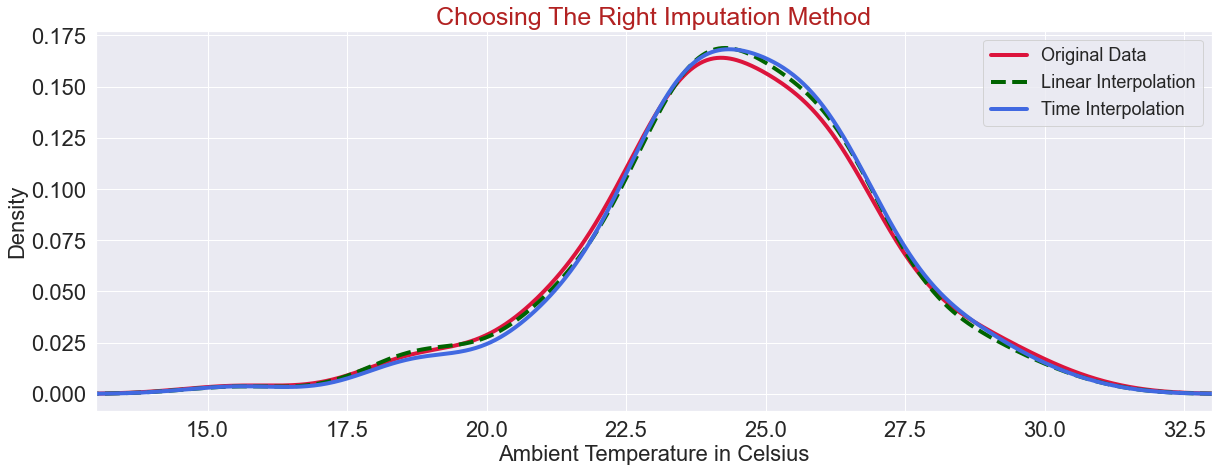

In [175]:
### Plotting Density Plots
plt.figure(figsize=[20,7])
plt.title('Choosing The Right Imputation Method', fontsize=25, color='firebrick')

### the data before interpolation
indoor4.ambient_temp_c.plot(kind='kde', c='crimson', linewidth=4)

### the data after interpolation
indoor4.ambient_temp_c_linear.plot(kind='kde', c='darkgreen', linewidth=4,  linestyle='--')
indoor4.ambient_temp_c_time.plot(kind='kde', c='royalblue', linewidth=4)
plt.legend(['Original Data','Linear Interpolation','Time Interpolation'], fontsize=18)
plt.xlim([13,33])
plt.xlabel('Ambient Temperature in Celsius', fontsize=22)
plt.ylabel('Density', fontsize=22)
plt.show()

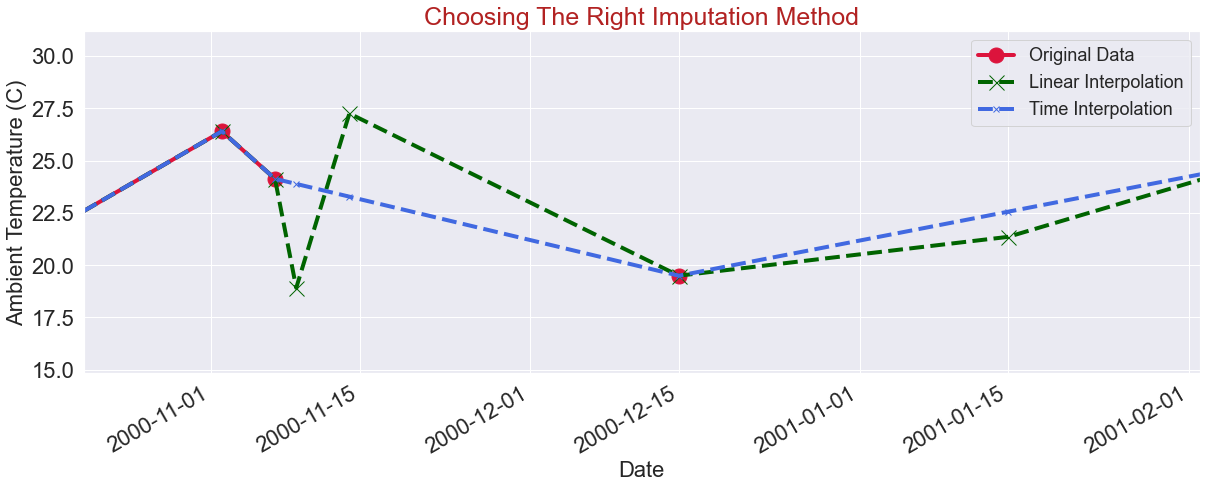

In [176]:
### Plotting Time Series
plt.figure(figsize=[20,7])
plt.title('Choosing The Right Imputation Method', fontsize=25, color='firebrick')

### the data before interpolation
sns.set(font_scale=2)
indoor4.ambient_temp_c.plot(c='crimson', linewidth=4, marker='o', markersize=15)

### the data after interpolation
indoor4.ambient_temp_c_linear.plot( c='darkgreen', marker='x', markersize=15, linewidth=4,  linestyle='--')
indoor4.ambient_temp_c_time.plot(c='royalblue', linewidth=4, linestyle='--', marker='x')
plt.legend(['Original Data','Linear Interpolation','Time Interpolation'], fontsize=18)
plt.xlim([11250,11355])
plt.xlabel('Date', fontsize=22)
plt.ylabel('Ambient Temperature (C)', fontsize=22)
plt.show()

The density plot does not show any dramatic differences in the shape of the data after imputation (which is good) however it does not help much to discriminate which method is the best to use here (which is not good). Plotting the imputed data versus the original data shows that the 'time' method is the best to work with because it imputes data that 'melts' into the original data according the datetime index. The 'linear' method backfilled nans as it went through the dataframe, which created undesirable kinks in the data. I assume that the 'linear' method would have worked better if I had sorted the data somehow prior to running interpolate.

I am now using .interpolate() with the 'time' method to fillup nans and zero values in other time series.

In [177]:
indoor4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2000-10-17 to 2000-08-30
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   homeid                 117 non-null    object 
 1   airtype                117 non-null    object 
 2   pm25                   117 non-null    float64
 3   landuse_class          117 non-null    object 
 4   ambient_temp_c         102 non-null    float64
 5   ambient_rh             117 non-null    float64
 6   airexrate              117 non-null    float64
 7   temp_dry               113 non-null    float64
 8   dew_point              113 non-null    float64
 9   temp_wet               113 non-null    float64
 10  rh                     113 non-null    float64
 11  common_id              117 non-null    object 
 12  pm25_log_np            117 non-null    float64
 13  pm25_log_pt            117 non-null    float64
 14  ambient_temp_c_linear  117 non-null    

In [178]:
### Interpolation with 'time'
outdoor4['ambient_temp_c'].loc[outdoor4['ambient_temp_c']==0.]=np.nan
outdoor4['ambient_temp_c_time']=outdoor4.ambient_temp_c.interpolate(method='time')

indoor4['airexrate'].loc[indoor4['airexrate']==0.]=np.nan
indoor4['airexrate_time']=indoor4.airexrate.interpolate(method='time')

col_dict={'ambient_rh':'ambient_rh_time',
          'temp_dry' : 'temp_dry_time',
          'dew_point' : 'dew_point_time', 
          'temp_wet' : 'temp_wet_time', 
          'rh' : 'rh_time'}
for oldcol, newcol in col_dict.items():
    indoor4[oldcol].loc[indoor4[oldcol]==0.]=np.nan
    indoor4[newcol]= indoor4[oldcol].interpolate(method='time')
    outdoor4[oldcol].loc[outdoor4[oldcol]==0.]=np.nan
    outdoor4[newcol]= outdoor4[oldcol].interpolate(method='time')

C:\Users\Anne\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Anne\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Anne\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  il

In [179]:
### As ambient_rh time series starts with 3 Nans
### the data is filled with the 4th value
fourth_out=float(outdoor4['ambient_rh_time']['2000-12-15'])
fourth_in=float(indoor4['ambient_rh_time']['2000-12-15'])
fourth_date=['2000-10-17','2000-09-26','2000-11-09']
for date in fourth_date:
    outdoor4['ambient_rh_time'][date]=fourth_out
    indoor4['ambient_rh_time'][date]=fourth_in

C:\Users\Anne\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Anne\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


I expect covariance between the different temperature and humidity measurements because they are mechanistically related. I do not expect covariance of these with the PM 2.5 data.

In [180]:
### Subsetting numerical values only
indoor4_num=indoor4[['pm25', 'pm25_log_pt', 
                    'ambient_temp_c_time', 'ambient_rh_time',
                    'temp_dry_time', 'dew_point_time', 'temp_wet_time',
                    'rh_time','airexrate_time',]]
outdoor4_num=outdoor4[[ 'pm25', 'pm25_log_pt', 
                      'ambient_temp_c_time', 'ambient_rh_time',
                      'temp_dry_time', 'dew_point_time', 'temp_wet_time',
                      'rh_time']] 

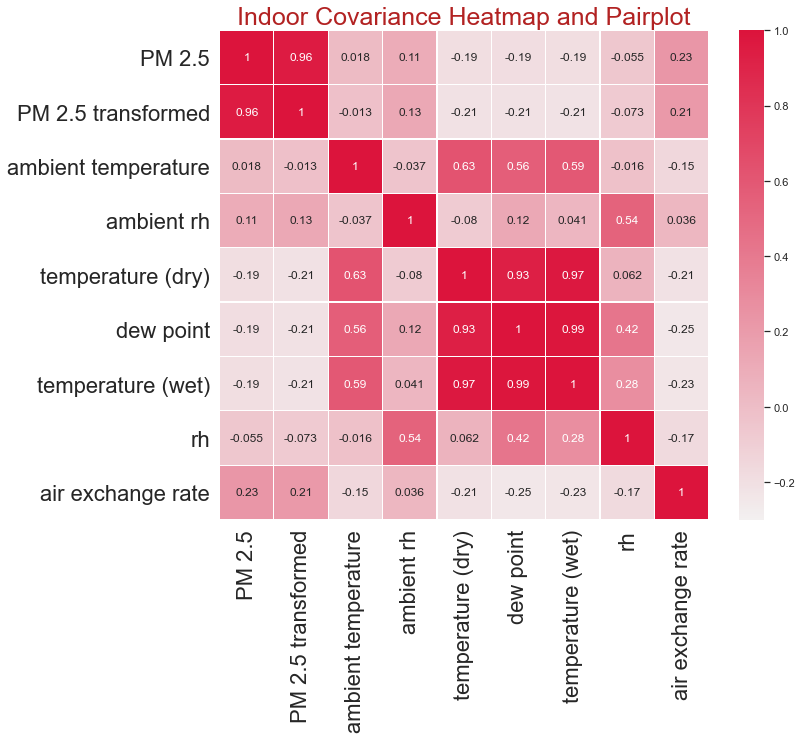

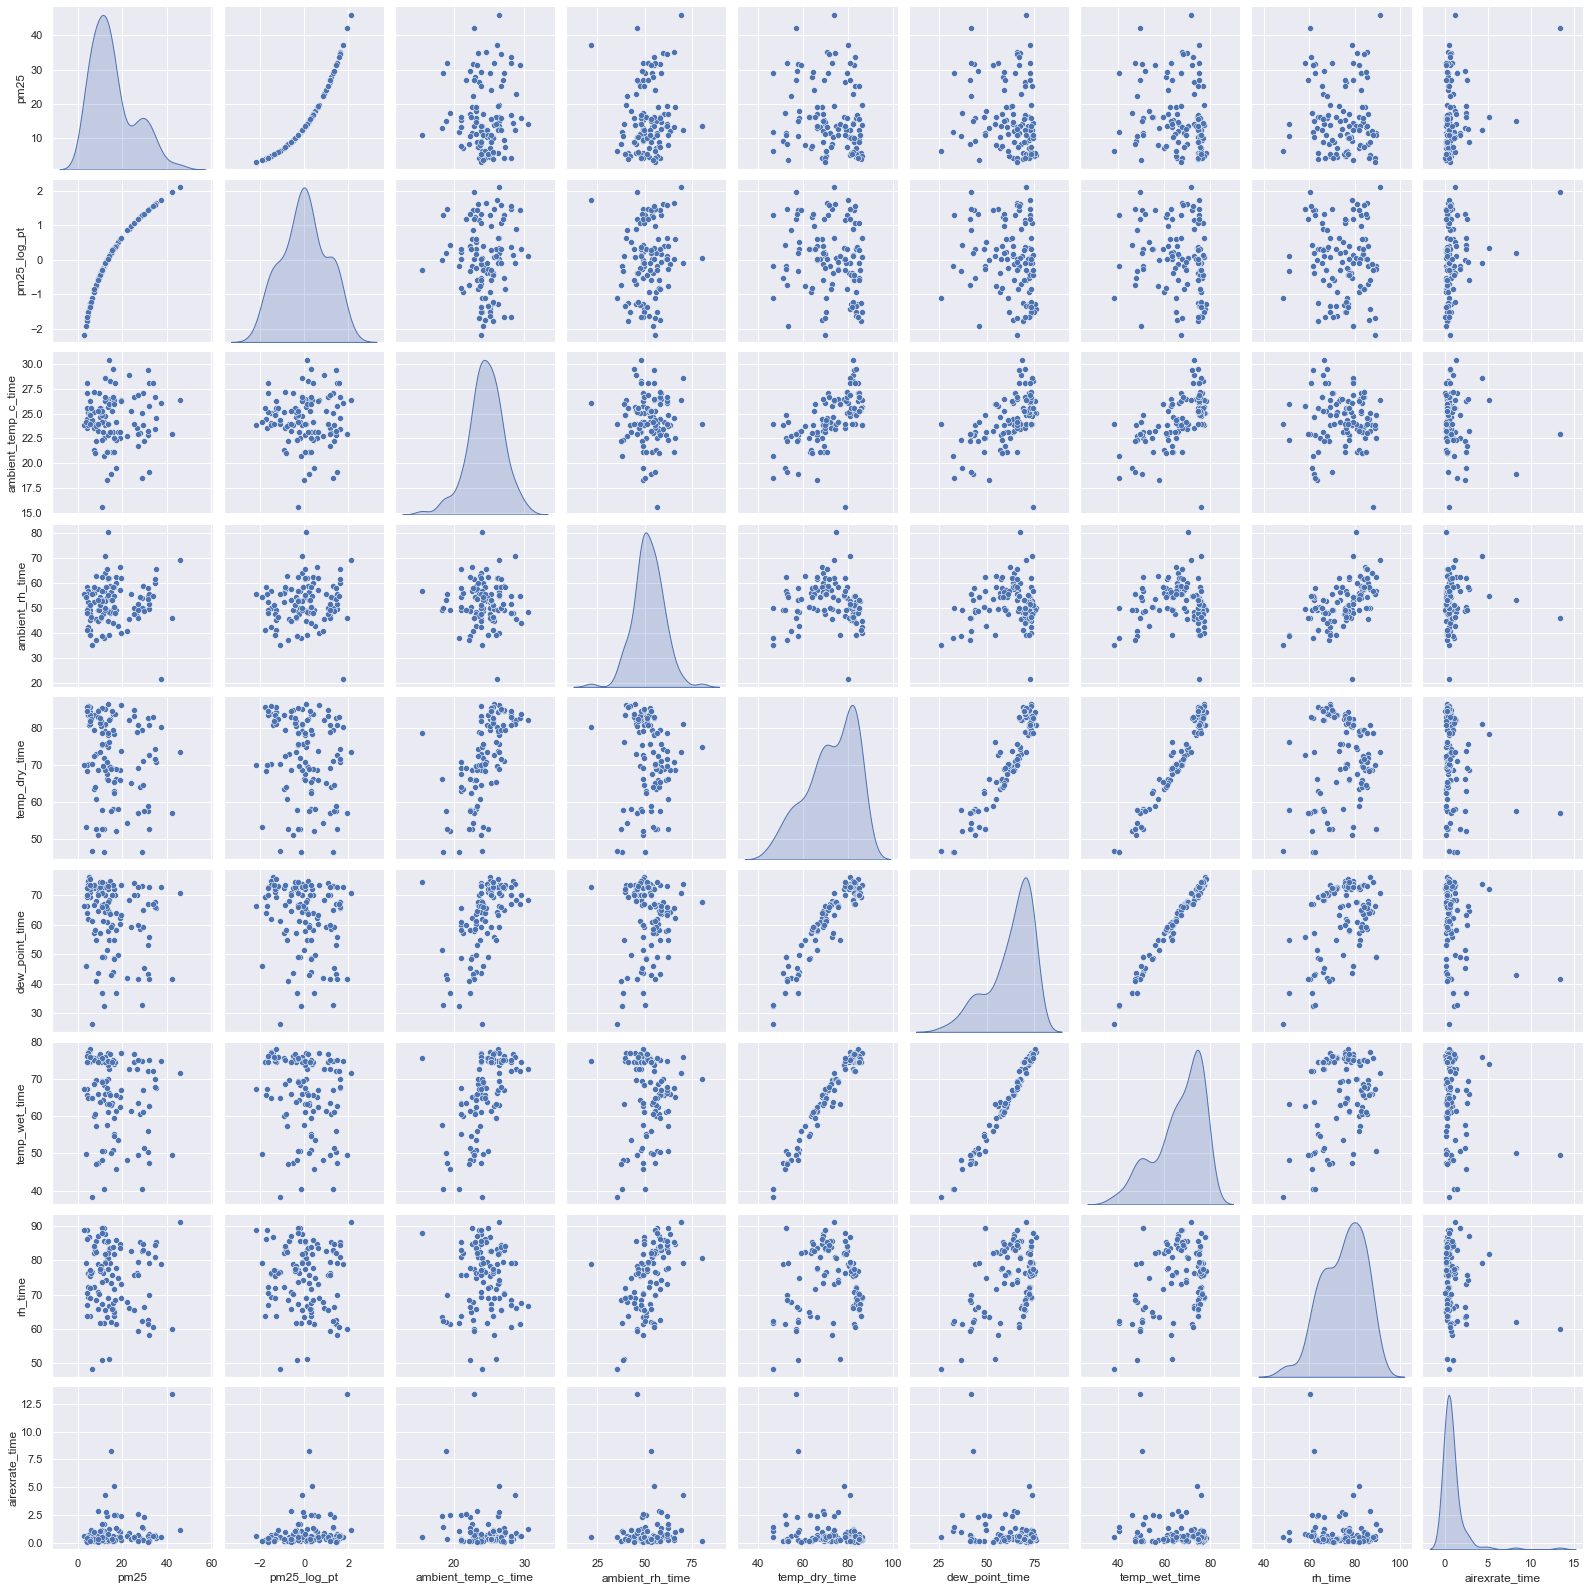

In [181]:
### Creating the covariance matrix of indoor data
indoor4_num_corr= indoor4_num.corr()

### Ploting covariance as a heatmap
fig, ax = plt.subplots(figsize=(11, 9))
indoorticks={'PM 2.5':'','PM 2.5 transformed':'','ambient temperature':'',
             'ambient rh':'','temperature (dry)':'','dew point':'',
             'temperature (wet)':'','rh':'','air exchange rate':''}
sns.set(font_scale=1)
ax.set_title('Indoor Covariance Heatmap and Pairplot', fontsize=25, color='firebrick')
cmapcrimson=sns.light_palette('crimson', as_cmap=True)
sns.heatmap(indoor4_num_corr, annot=True, cmap=cmapcrimson ,
            vmin= -0.3, vmax=1, square=True, linewidth=0.3, 
            xticklabels=indoorticks, yticklabels=indoorticks)

### Ploting Pairplot
sns.pairplot(indoor4_num, kind='scatter', diag_kind='kde')

plt.show()

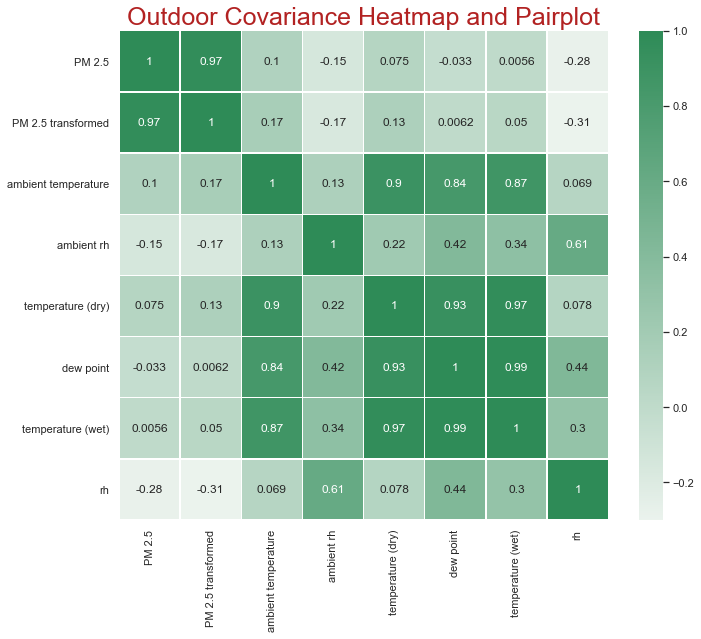

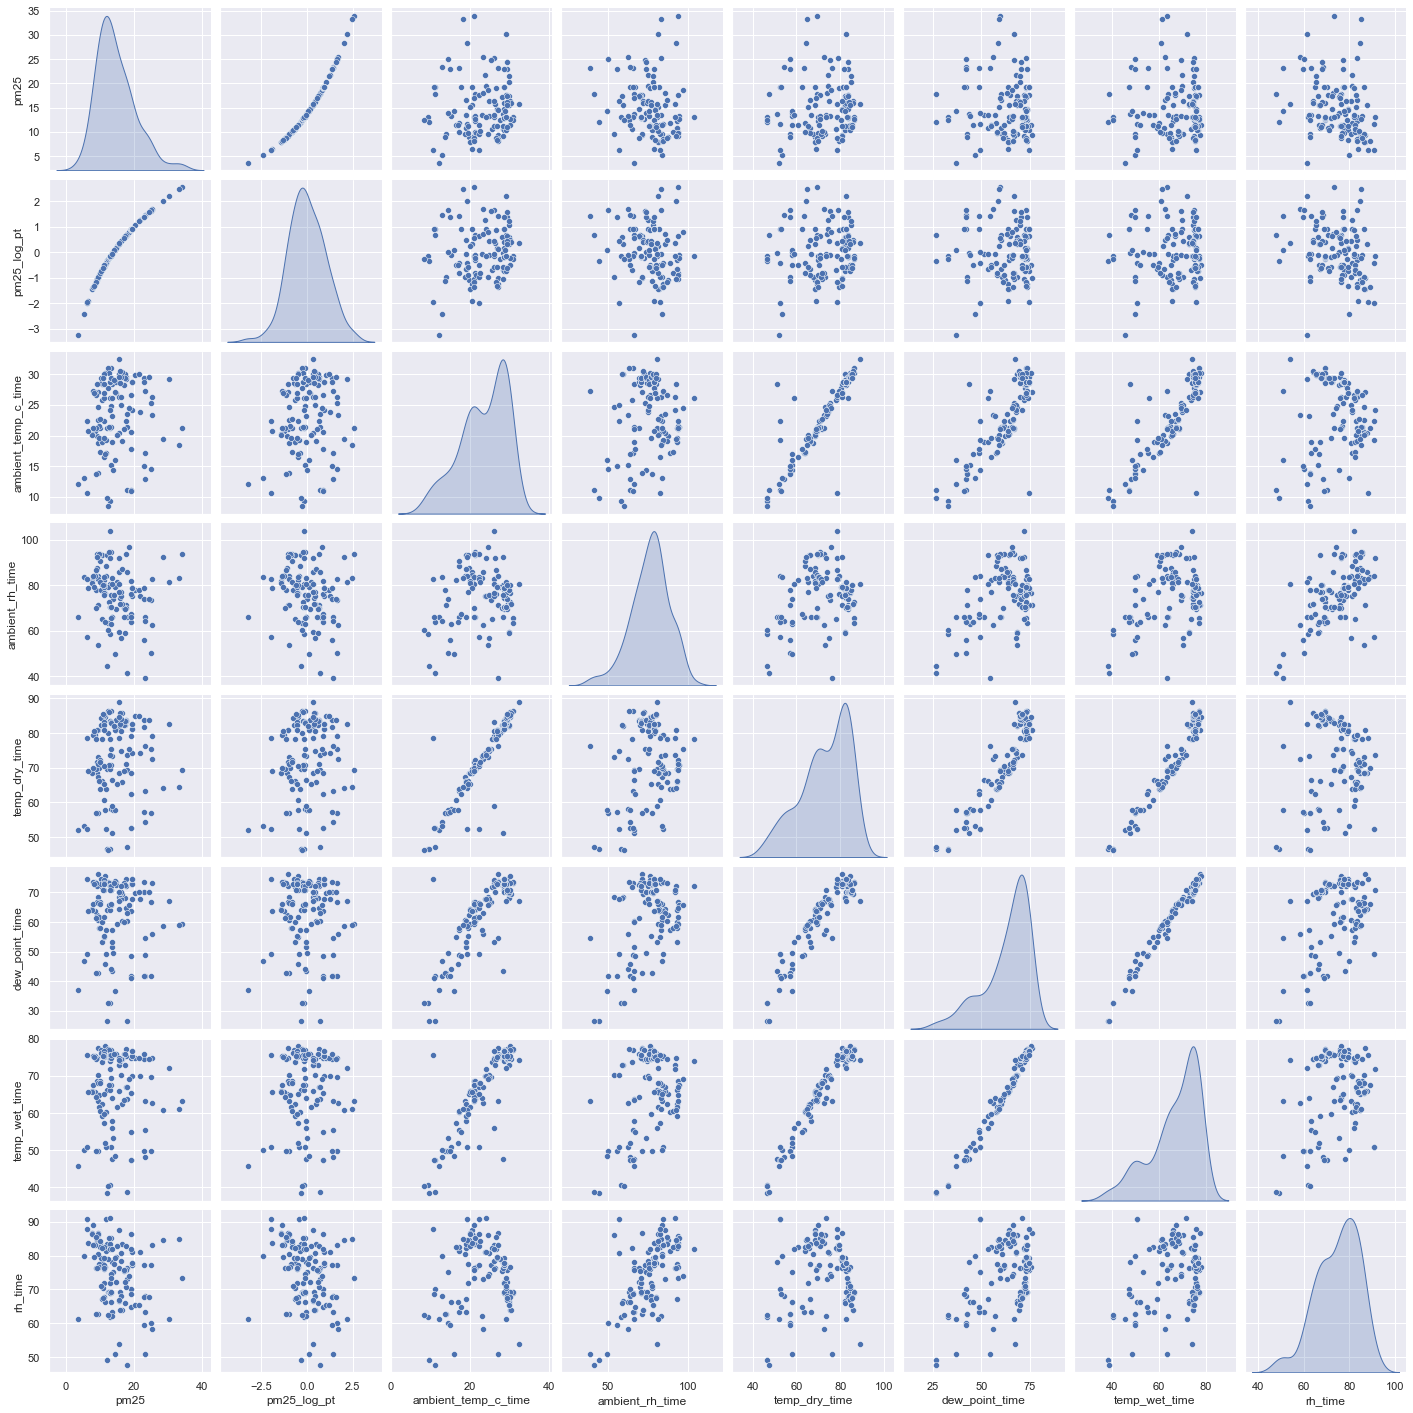

In [182]:
### Creating the covariance matrix of outdoor data
outdoor4_num_corr= outdoor4_num.corr()

### Ploting covariance as a heatmap
fig, ax = plt.subplots(figsize=(11, 9))
sns.set(font_scale=1)
outdoorticks={'PM 2.5':'','PM 2.5 transformed':'','ambient temperature':'',
             'ambient rh':'','temperature (dry)':'','dew point':'',
             'temperature (wet)':'','rh':''}
ax.set_title('Outdoor Covariance Heatmap and Pairplot', fontsize=25, color='firebrick')
cmapseagreen=sns.light_palette('seagreen', as_cmap=True)
sns.heatmap(outdoor4_num_corr, annot=True, cmap=cmapseagreen ,
            vmin= -0.3, vmax=1, square=True, linewidth=0.3, 
            xticklabels=outdoorticks, yticklabels=outdoorticks)

### Ploting Pairplot
sns.pairplot(outdoor4_num, kind='scatter', diag_kind='kde')

plt.show()

As expected there is no covariance besides between measured temperatures (i.e. ambient temperature, temperature (dry) and temperature (wet)). This data could be averaged into one feature 'temperature' in each dataset.

On the side of categorical data, the story is quite different. To facilitate the reading of plots, the initial landuse terms have been simplified and of course saved in a dictionary (landuse_dict):
- low intensity residential: resid low
- high intensity residential: resid hi
- pasture, hay: pasture
- deciduous forest: forest dec
- mixed forest: forest mix
- evergreen forest: forest evr
- urban, recreational grasses: urban grass
- emergent herbaceous wetlands: wetlands
- unknown: unknown

In [239]:
### Updating the dataframe using new landuse terms
### whic are stored in the landuse_dict

landuse_dict={'low intensity residential': 'resid low',
              'high intensity residential': 'resid hi',
              'pasture, hay': 'pasture',
              'deciduous forest': 'forest dec',
              'mixed forest': 'forest mix',
              'evergreen forest': 'forest evr',
              'urban, recreational grasses': 'urban grass',
              'emergent herbaceous wetlands': 'wetlands',
              'tbd': 'unknown',
              np.nan: 'unknown'}
landuse_list=['resid low', 'resid hi', 'pasture',
              'forest dec', 'forest mix', 'forest evr',
              'urban grass', 'wetlands', 'unknown']

outdoor4['landuse']=outdoor4.landuse_class.replace(landuse_dict)
indoor4['landuse']=indoor4.landuse_class.replace(landuse_dict)            

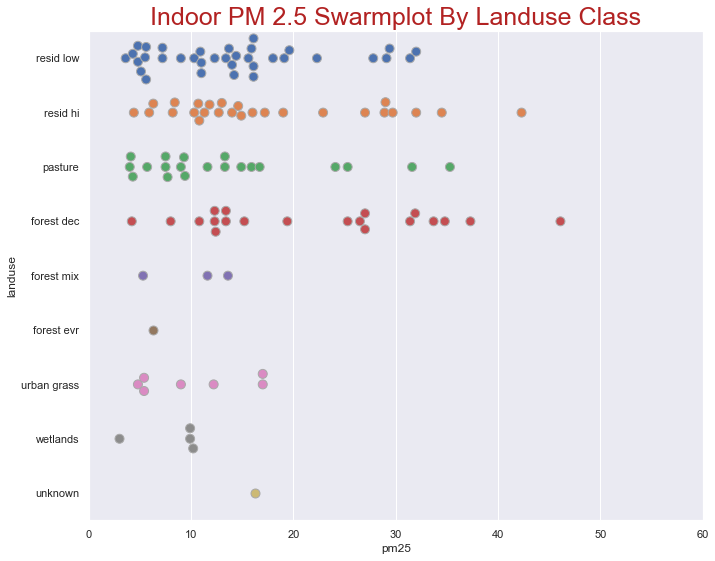

In [266]:
fig, vli = plt.subplots(figsize=(11, 9))
vli.set_title('Indoor PM 2.5 Swarmplot By Landuse Class', fontsize=25, color='firebrick')
sns.set(font_scale=1)
sns.swarmplot(y='landuse', x='pm25', data=indoor4,  
               order=landuse_list, edgecolor='darkgray',
              linewidth=1, size=9)

plt.xlim([0,60])
plt.show()

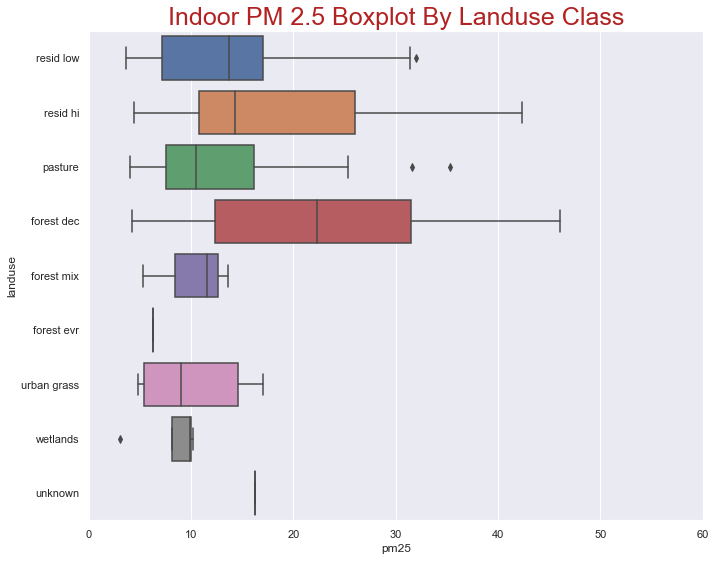

In [267]:
fig, vli = plt.subplots(figsize=(11, 9))
vli.set_title('Indoor PM 2.5 Boxplot By Landuse Class', fontsize=25, color='firebrick')
sns.set(font_scale=1)
sns.boxplot(y='landuse', x='pm25', data=indoor4, ax=vli, 
               order=landuse_list)

plt.xlim([0,60])
plt.show()

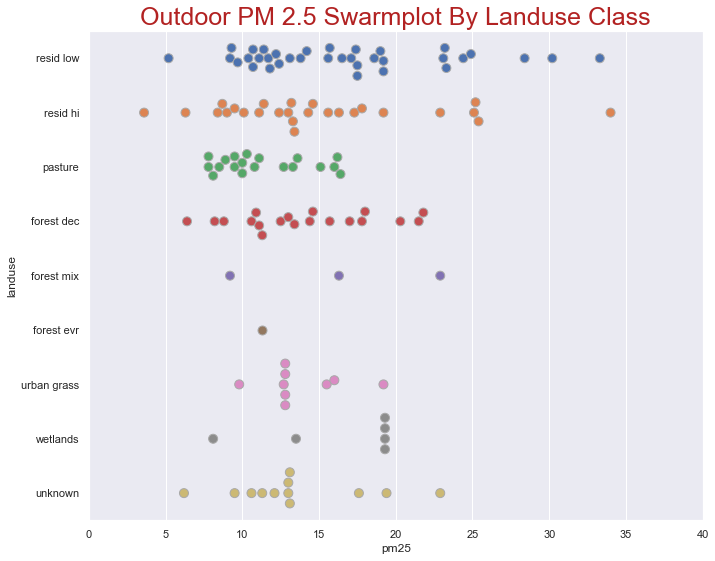

In [273]:
fig, vlo = plt.subplots(figsize=(11, 9))
vlo.set_title('Outdoor PM 2.5 Swarmplot By Landuse Class', fontsize=25, color='firebrick')
sns.set(font_scale=1)
sns.swarmplot(y='landuse', x='pm25', data=outdoor4,  
               order=landuse_list, edgecolor='darkgray',
              linewidth=1, size=9)

plt.xlim([0,40])
plt.show()

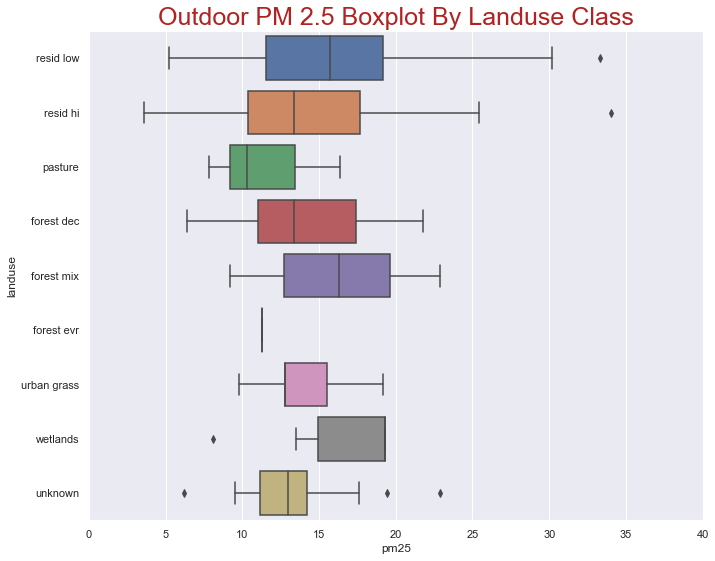

In [272]:
fig, vlo = plt.subplots(figsize=(11, 9))
vlo.set_title('Outdoor PM 2.5 Boxplot By Landuse Class', fontsize=25, color='firebrick')
sns.set(font_scale=1)
sns.boxplot(y='landuse', x='pm25', data=outdoor4, ax=vlo, 
               order=landuse_list)

plt.xlim([0,40])
plt.show()

Some remark about the categorical values... if I had the locatio nI could add traffic and emissions and other factors

### 1.2. Indoor vs Outdoor: ###
renaming columns ind / out
merging both renamed ds
checked directr relationship of pm 2.5
check covariance
see some groupby landuse relationship


### 1.3. Conclusion and Export for Featuring: ###
summarize/conclude